In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Part 3b - Building a flair detector

## FastAI ULMFit

In [0]:
# Get the required libraries

from fastai.text import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
# Load the dataset and split it into training and validation sets

df = pd.read_csv('/content/gdrive/My Drive/MIDAS/makedata/balanced_data.csv')
df = df[['flair', 'title']]
train, val = train_test_split(df, stratify = df['flair'], test_size = 0.15)

In [4]:
# Loading the dataset into FastAI's databunch, for the language model and the classifier

language_model_data = TextLMDataBunch.from_df("", train, val)
classifier_data = TextClasDataBunch.from_df("", train, val, vocab=language_model_data.train_ds.vocab, bs=32)

### The language model
We train the language model using ASGD Weight-Dropped LSTM (AWD-LSTM) architecture. It is one of the most popular language models. It has been used in many top papers, and its performance in the character-level model is also excellent. More details here: https://yashuseth.blog/2018/09/12/awd-lstm-explanation-understanding-language-model/

In [5]:
language_model = language_model_learner(language_model_data, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 3.02E-02


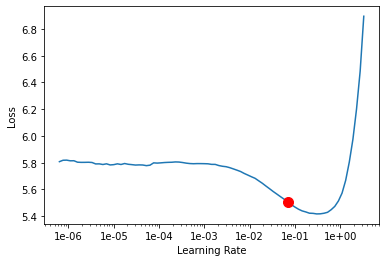

In [6]:
# We first use FastAI's automated learning rate suggester

language_model.lr_find()
language_model.recorder.plot(suggestion=True)
min_grad = language_model.recorder.min_grad_lr

In [7]:
language_model.fit_one_cycle(2, min_grad)

epoch,train_loss,valid_loss,accuracy,time
0,4.727507,4.301011,0.328438,00:29
1,3.976210,4.042277,0.348549,00:30


Right now, we just trained the top-most layers of the model. "Unfreezing" the model refers to all the layers being made trainable.

In [8]:
language_model.unfreeze()
language_model.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.550892,3.839465,0.369196,00:30


In [0]:
# Save the language model encoder

language_model.save_encoder('encoder')

### Classifier model
We will use a technique similar to the one used above, except in two steps. We will train the topmost layers, followed by unfreezing the next layers over two steps.

In [10]:
# Loading the language model trained above as an encoder for the classifier

classifier = text_classifier_learner(classifier_data, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25695 items)
x: TextList
xxbos xxmaj who else remember this ?,xxbos xxup caa xxmaj xxunk xxmaj will xxmaj have to xxmaj prove xxmaj they xxmaj declared xxmaj their xxmaj religion xxmaj before 2014,xxbos xxmaj get xxmaj more xxmaj xxunk xxmaj about xxmaj coronavirus xxmaj visit xxmaj this xxmaj website,xxbos xxmaj economic slowdown hits jobs sector : xxup sbi report,xxbos xxmaj marking the 5 year anniversary of the xxmaj shreya xxmaj singhal xxmaj judgement
y: CategoryList
AskIndia,CAA-NRC,Coronavirus,Policy/Economy,Policy/Economy
Path: .;

Valid: LabelList (4535 items)
x: TextList
xxbos xxmaj india ’s sugar production may drop 63 lakh tonnes in 2019 - 20,xxbos i took a picture of the moon this evening . [ xxmaj kolkata ] [ xxmaj sony xxunk - xxunk f / 4.5 - xxunk lens ] [ xxup iso100 , f / 10 , 1 / xxunk , xxunk ],xxbos xxmaj indians in xxmaj europe stand against xxup fascist xxup modi government . xxmaj we want xxunk and united xxm

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 3.63E-02


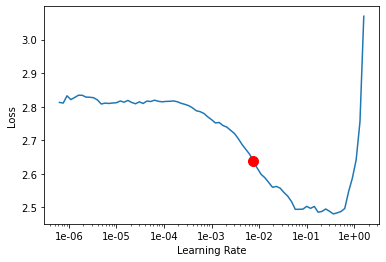

In [11]:
# Again, we use the automatic learning rate suggester for initial training

classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad = classifier.recorder.min_grad_lr

In [12]:
classifier.fit_one_cycle(3, min_grad)

# Unfreeze the next two layers
classifier.freeze_to(-2)
classifier.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8, 0.7))

# Unfreeze the entire model
classifier.unfreeze()
classifier.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.929322,1.749907,0.434620,00:34
1,1.801885,1.682309,0.460419,00:35
2,1.733437,1.647710,0.469901,00:34


epoch,train_loss,valid_loss,accuracy,time
0,1.712238,1.609512,0.480706,00:34
1,1.625708,1.538036,0.507608,00:31
2,1.529371,1.483669,0.523705,00:33
3,1.427550,1.474866,0.524587,00:34


epoch,train_loss,valid_loss,accuracy,time
0,1.374276,1.451659,0.534950,00:38
1,1.345362,1.418287,0.550827,00:38
2,1.283407,1.428266,0.556119,00:36
3,1.153175,1.415029,0.560088,00:35


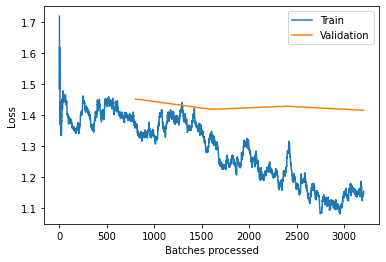

In [13]:
classifier.recorder.plot_losses()

### Testing

In [29]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import numpy as np

preds, Y_test, losses = classifier.get_preds(with_loss=True)
matrix = ClassificationInterpretation(classifier, preds, y, losses)
Y_test = np.asarray(y)
preds = np.asarray([np.argmax(line) for line in preds])

print("Accuracy = {}".format(accuracy_score(Y_test, preds)))
print("F1 score = {}".format(f1_score(Y_test, preds, average='macro')))
print("Precision = {}".format(precision_score(Y_test, preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, preds, average='macro')))

Accuracy = 0.5600882028665931
F1 score = 0.5675320660607658
Precision = 0.5683365320399466
Recall = 0.5711759346602856


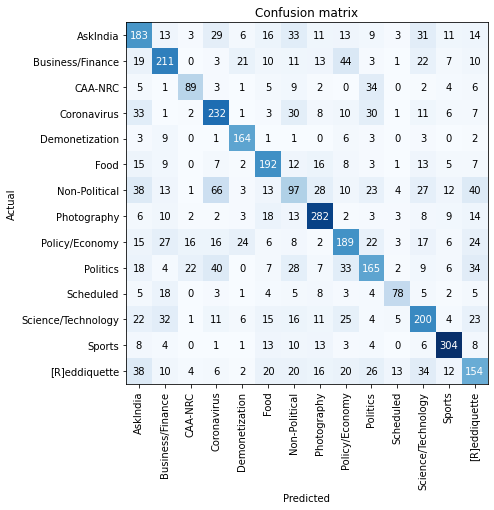

In [31]:
matrix.plot_confusion_matrix(figsize=(7, 7))